# Classification 

Classification modelling is a branch of machine learning concerned with separating sets of objects.

To do this we usually want to predict from a vector $\mathbf{x}$ what class it belongs to, $y$. The class can be different species of dog, different human faces, the phase of a thermodynamic system to name a few. In this example you'll be working with simulated student data to predict whether they get a pass or fail grade with three different models. 

Your learning goals for this project is: 
* Improved understanding of the `scikit-learn` pipeline for modelling, building on the regression tutorial 
* Imroved understanding of machine learning concepts: generalization, overfitting, model set, feature scale, and class bias
* Understanding the difference between linear and non-linear models 
* Understanding some important classification measurements: Area under Curve, Reciever Operator Characteristic, Precision, Recall 
* Understanding the goal of classification modelling

## Further Reading: 


1. A high-bias, low-variance introduction to machine learning, a good introduction for physicists to machine learning concepts https://arxiv.org/abs/1803.08823
2. The Elements of Statistical Learning, a very good textbook giving an introduction to much of the theory used in machine learning https://web.stanford.edu/~hastie/Papers/ESLII.pdf

# Classifying failure in a class

In this project the aim is to predict whether a studen fails or passes a course. The data has the following columns:

*         "cGPA": college GPA 
*        "attendance": attendance percent
*       "passed_percent": percent of courses passed
*      "sex": self reported sex of the student
*     "hsGPA": high school GPA
*    "ethnicity": self reported ethnic identity of the student
*   "failed_course": whether the student failed the course (1) or not (0)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, cohen_kappa_score

from scipy.stats import spearmanr, pearsonr

def calculate_pvalues(df,
                      method = spearmanr
                     ):
    """
    Assumes df with only numeric entries clean of null entries. 
    """
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(method(df[r], df[c])[1], 4)
    return pvalues

def correlation_matrix(df,
                       method = "pearson",
                       annot_bool = False,
                       annot_size = 20
                      ):
    # Compute the correlation matrix
    corr = df.corr(method = method)

    if annot_bool:
        annot = corr.copy()
        
        if method == "pearson":
            sig_meth = pearsonr
        else:
            sig_meth = spearmanr
            
        pval = calculate_pvalues(df, sig_meth) 
        # create three masks
        r0 = corr.applymap(lambda x: '{:.2f}'.format(x))
        r1 = corr.applymap(lambda x: '{:.2f}*'.format(x))
        r2 = corr.applymap(lambda x: '{:.2f}**'.format(x))
        r3 = corr.applymap(lambda x: '{:.2f}***'.format(x))
  
        # apply them where appropriate --this could be a single liner
        annot = annot.where(pval>0.1,r0)
        annot = annot.where(pval<=0.1,r1)
        annot = annot.where(pval<=0.05,r2)
        annot = annot.mask(pval<=0.01,r3)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot = annot,
                fmt = "",
                annot_kws={"size": annot_size},
                vmin = -1,
                vmax = 1,
               )

## Data

The data is included in the `data` folder in a python pickle file-format. Pandas has a function to read this data into a data-frame; `pd.read_csv(file_name)`. If you prefer not to load files from an untrusted source the data can be generated from the associated notebook. 

#### filename: `classification_data.csv`



In [2]:
df = pd.read_csv('data/classification_data.csv')

### Task 1a:  Exploration
Prior to any modelling it is important to understand the type of data you're working with. Many models behave differently under differently scaled features, as well explore later in this project. And some models have different implications for interpretability under multicolinearity in the features. Logistic Regression (LR), perhaps the most simple classifying algorithm, is one such. In LR the coefficients can be interpreted as the change in log odds for a given feature. What does this mean for a feature which can be expressed as a linear combination of others in the same system? As such the use of data exploration, and preprocessing tools like principal component analysis etc. is vital both for performance and in some cases completely necessary for interpretability of the model.  

In this task you should:
1. visualize all the features and their distributions. 
2. Like in the regression task you should also investigate the covariance matrix. Will covariance have a different impact for classification than for regression? What models will it impact? 
3. Visualize the class distribution the dependent variable: `failed_course`. What challenges does this distribution pose, if any? 

In [3]:
df.head()

,cGPA,attendance,passed_percent,sex,hsGPA,ethnicity,failed_course
0,2.804237,20.729776,44.264054,1.0,1.375473,0.0,0.0
1,2.801956,35.256924,45.859841,0.0,1.979025,0.0,0.0
2,2.707675,30.902179,59.624675,0.0,1.392150,1.0,0.0
3,2.430461,35.741390,79.016129,1.0,1.629601,1.0,0.0
4,2.715655,32.691236,76.988142,1.0,1.920502,2.0,0.0


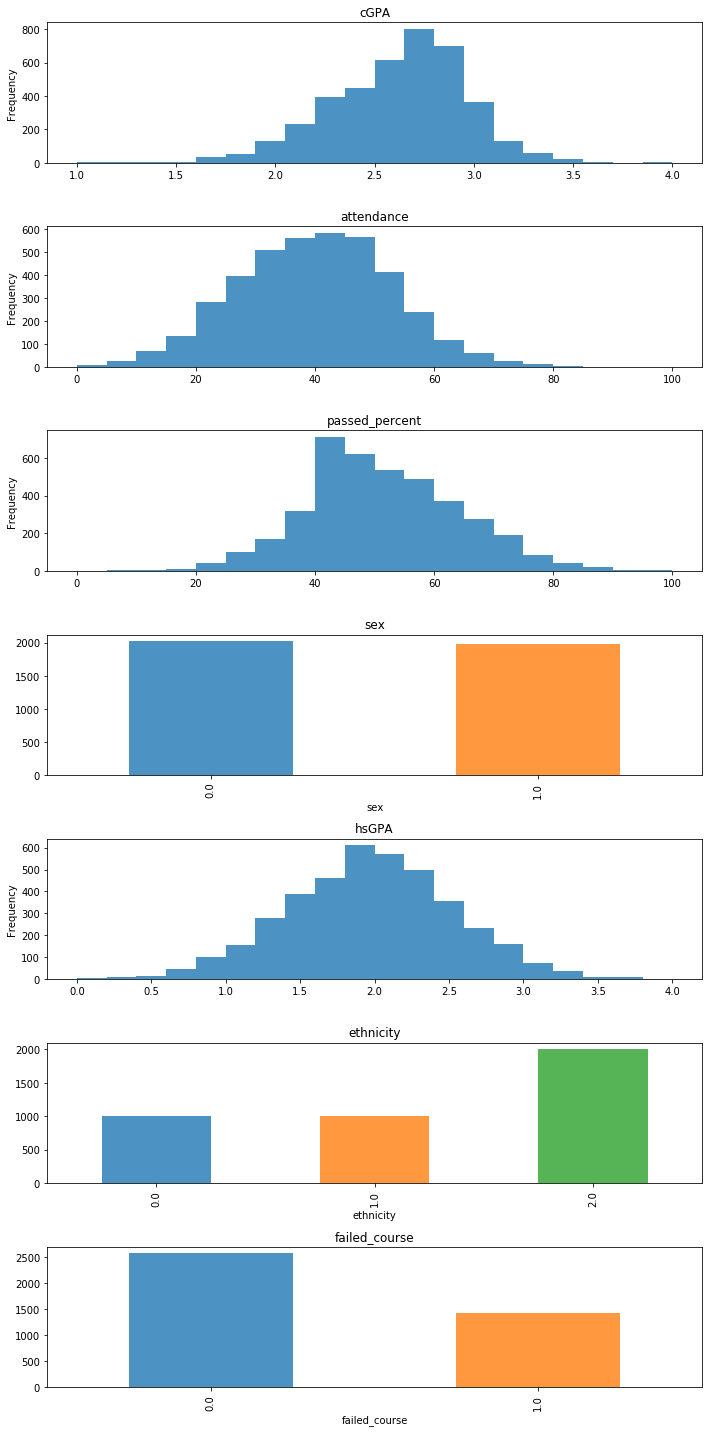

In [4]:
columns = df.columns
fig, axs = plt.subplots(nrows=len(columns), figsize=(10, 20))

for i in range(len(columns)):
    col = columns[i]
    ax  = axs[i]
    n_unique = df[col].nunique()
    if n_unique < 5:
        kind = "bar"
        df.groupby(col).count()["cGPA"].plot(kind="bar", ax=ax, alpha=.8)
    else:
        n_hist = 20       
        df[col].plot(kind="hist", bins=n_hist, ax=ax, alpha=.8)
    ax.set_title(col)
    
plt.tight_layout()

In [5]:
percent_passed = sum(df["failed_course"] == 0)/len(df["failed_course"])
print("Percent who pass: {:.2f}%".format(percent_passed*100))

Percent who pass: 64.22%


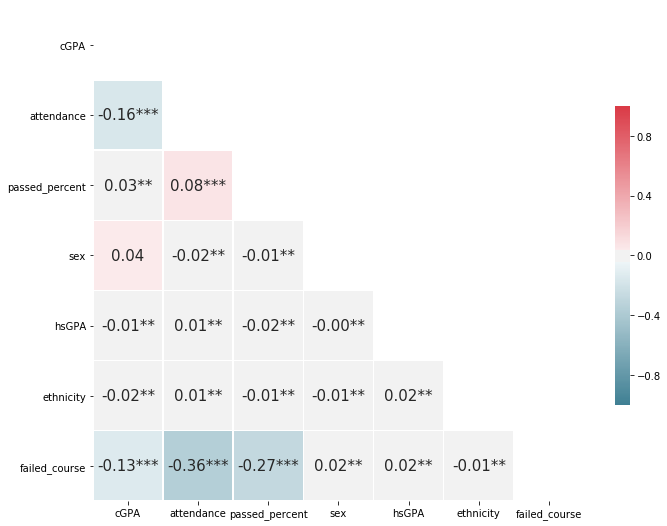

In [6]:
correlation_matrix(df, annot_bool=True, annot_size=15)

We observe that the outcome class `failed_course` is not evenly distributed, more students pass than fail this particular course. This will inform our choice of performance metric, vanially accuracy might not be the best choice for this dataset. We also note that there  is a small, negative correlation between attendance and college GPA which might influence the interpretability of linear-model coefficients. 

### Task 1b: Scaling
A major part of data analysis and modelling is being aware of the impacts of the distribtions of values in the features on a given model. As an example consider a neural network with a sigmoid activation, values above or below ~4 asymptotically approach 1 or -1 respectively. A feature distributed as $x $~$\mathcal{N}(\mu=100, \sigma=2) $ for example will then have the same activation for all values of x, which leads to the model being unable to learn anything from that feature. This applies to Logistic Regression as well which also uses the logistic sigmoid function. Scaling enables much faster learning from features originally outside the "range" of the function.


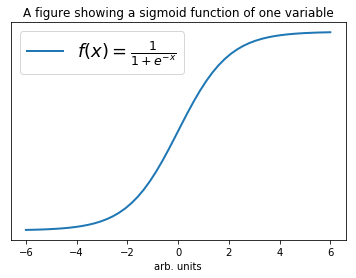

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def logistic(x): return 1/(1 + np.exp(-x))

x = np.linspace(-6, 6)
y = logistic(x)

plt.plot(x, y, label=r"$f(x) = \frac{1}{1+e^{-x}}$", linewidth=2)
plt.yticks([])
plt.xlabel("arb. units")
plt.legend(fontsize=18)
plt.title("A figure showing a sigmoid function of one variable")
plt.show()


For this task you should:
1. consider which features are suitable for scaling
2. consider the z-scaling function: $f(x) = \frac{x - \mu}{\sigma}$ where $\mu=\langle x \rangle$ and $\sigma^2= \langle x^2 \rangle - \langle x \rangle^2$. What impact does this function have on a normally distributed feature $x $~$N(\mu, \sigma^2)$? (you don't have to solve this by pen and paper - empirically showing by plotting is fine)
3. Scale suitable features with a z-scaling function. Keep a copy of the unscaled data.


The non-categorical features shold be scaled, they are: 
* `cGPA`
* `attendance`
* `hsGPA`
* `passed_percent`

The  z-scaling function transforms any normally distributed variable to a zero mean, unit variance gaussian. We demonstrate this by scaling a distribution with $\mu = 50$, $\sigma = 5$

Text(0.5,0,'arb. units')

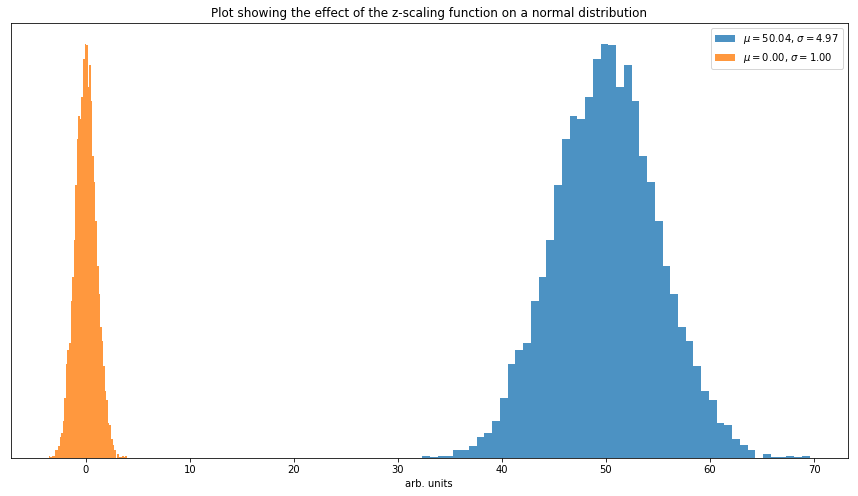

In [8]:
#normal distribution with 

fig, axs = plt.subplots(1, figsize=(15, 8))
norm = np.random.normal(50, 5, size=10000)
mu_1 = norm.mean()
sigma_1 = norm.std()

axs.hist(
    norm,
    bins=50,
    alpha=.8,
    label=r"$\mu=${:.2f}, $\sigma=${:.2f}".format(mu_1, sigma_1),
)

scaled = (norm-mu_1)/sigma_1
mu_2 = scaled.mean()
sigma_2 = scaled.std()

axs.hist(
    scaled,
    bins=50,
    alpha=.8,
    label=r"$\mu=${:.2f}, $\sigma=${:.2f}".format(mu_2, sigma_2),
)

axs.legend()
axs.set_title("Plot showing the effect of the z-scaling function on a normal distribution")
axs.set_yticks([])
axs.set_xlabel("arb. units")


In [9]:
def z_scale(x): return (x - x.mean())/x.std()

scaled_df = df.copy()
to_scale = [
    "cGPA",
    "attendance",
    "hsGPA",
    "passed_percent"
]

for c in to_scale:
    unscaled_feature = df[c].values
    scaled_feature = z_scale(unscaled_feature)
    scaled_df[c] = scaled_feature

In [10]:
scaled_df.describe()

,cGPA,attendance,passed_percent,sex,hsGPA,ethnicity,failed_course
count,4.000000e+03,4.000000e+03,4.000000e+03,4000.000000,4.000000e+03,4000.00000,4000.000000
mean,1.395523e-15,-2.649513e-16,8.279488e-17,0.494500,-8.942153e-17,1.25000,0.357750
std,1.000125e+00,1.000125e+00,1.000125e+00,0.500032,1.000125e+00,0.82926,0.479398
min,-4.760271e+00,-3.098315e+00,-3.991237e+00,0.000000,-3.575142e+00,0.00000,0.000000
25%,-6.435288e-01,-7.041587e-01,-6.761093e-01,0.000000,-6.721882e-01,0.75000,0.000000
50%,1.311288e-01,1.729381e-02,-8.950115e-02,0.000000,6.831845e-03,1.50000,0.000000
75%,6.663447e-01,6.807774e-01,6.619261e-01,1.000000,6.575731e-01,2.00000,1.000000
max,4.041320e+00,4.673535e+00,3.766255e+00,1.000000,3.656794e+00,2.00000,1.000000


## Modelling

Classification models are formulated somewhat differently than regression models, but many of them actually optimize  the same problem and will have the same minimum. In that way Linear Regression solved by OLS serves as a natural bridge to the model we'll introduce, namely; Logistic Regression (Artificial Neural Networks can be used but will be introduced in a different project). A third model we'll briefly introduce, Random Forests, has a slightly different formalization, but this difference is very convenient in many cases as we'll get back to.

Because of the problem of overfitting (using a more complex function to approximate a lower complexity phenomena) the data needs to be split in "training" and "test" sets. The sets are disjoint, which is to say that there is no common element to them. The training data is used to fit the model, and the test data is used to check the out-of-sample (OOS) generalization error, which measures how good we think the model will do on unseen "real-world" data. 

### Logistic Regression

We'll build up logistic regression (LR) by first considering a simpler model: the perceptron.
The perceptron is a linear model on the form 

$s_i = \mathbf{x}^T_i \mathbf{w} + b $

Where we cast this to a discrete output by the sign of $s_i$, i.e. $f(s_i) = sign(s_i)$. This obviously simple model was introduced earliy in the second half of the 20th century and was the foundation for neural networks today. In cases with noisy data the perceptron fails miserrably as it has no notion of how likely it is that a sample is in one class or the other. It then became preferable to have a "soft" classifier. Which is to say a classifier with output that can be treated as a probability. One such model is the logistic regression, which uses a sigmoid function to cast a unbounded input to a probability. The logistic sigmoid function which is the one such sigmoid we'll use is formulated as: 

$f(s) = \frac{1}{1 + e^{-x}}$

This function is obviously bounded as $f(s) \in [0, 1]$, making it suitable to model a probability. It also has some nice properties that is useful in that it's monotonic and approaches a linear function at the origin. To see how it links to a a probability output we consider the odds which is simply a ratio of the probability of an event to a non-event. 

$o(p) = \frac{p}{1-p}$

The odds of an event is  a useful quantity, but hard to model as it is bounded in $\mathcal{R}_+$ we instead consider the log-odds, or logit:

$logit(p) = \log{(o(p))}$

Which is not bounded, making it convenient to model. Additionally it ties to the logistic function as a logit input to the sigmoid is the probability of that event. 

$f(\log(o(p)) = \frac{1}{1+e^{\log{(o(p))}}} = p$

The input to the logistic function the can be interpreted as log-odds, and we then formulate logistic regression as: 

$P(y_i = 1 |\mathbf{x_i}; \mathbf{w}, b) = \frac{1}{1+e^{\mathbf{x}_i^T\mathbf{w} + b}}$

The above equation reads as: 
* The probability that event $y_i$ happens. Where the event could for example that a student fails a class.
* Given a datapoint, $\mathbf{x_i}$ containing student information like GPA, attendance, gender etc.
* And the model parameters $\mathbf{w}$ which are constant with regard to changing the input and output, thus we separate it with a semicolon.

This formulation means that we can interpret the coefficients of our model, $\mathbf{w}$, when fit as relative log-odds for an event, giving us a nice interpretability of our model. The fitting procedure for this model is outside the scope of this lecture, but can be found in the paper by Mehta et. al listed at the head of this notebook.

### Task 2: fitting models 

In this task you should: 

1. Using `scikit-learn` the data must be appropriately split in separate data-sets
2. Fit a classification model from `scikit-learn` to the appropriate data (implementing this as a function is recommended)
3. Evaluate this model using two different classification metrics. You should also plot the Reciever Operator Characteristic curve. What do they tell you? 

#### Extra:
4. Evaluate whether the scaling impacts the model performance

In [11]:
data_cols = [c for c in columns if c != "failed_course"]
X = df[data_cols].values
y = df["failed_course"].values
x_train, x_test, y_train, y_test = train_test_split(X, y,)

model = LogisticRegression(solver="lbfgs", class_weight="balanced")
model.fit(x_train, y_train)

print("Acc score: {:.2f}".format(accuracy_score(y_test, model.predict(x_test))))
print("Cohen's Kappa: {:.2f}".format(cohen_kappa_score(y_test, model.predict(x_test))))

Acc score: 0.73
Cohen's Kappa: 0.44


Accuracy score just measures the percent correct predictions while Cohen's kappa can be interpreted as accuracy adjusted for chance. We separate it in levels of aggreement where $\kappa = 0.43$ denotes moderate agreement 

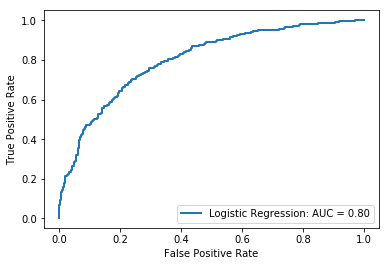

In [12]:
positive_class_prediction = model.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, positive_class_prediction)
auc = roc_auc_score(y_test, positive_class_prediction)

plt.plot(fpr, tpr, label="Logistic Regression: AUC = {:.2f}".format(auc), lw=2)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()

The reciever operator characteristic (ROC) measures the interplay between true and false positive rates as a function of the model threshold. The model threshold is the value above which we classify a prediction as one of the positive class. The default value for this is $t = 0.5$ s.t. a prediction is positive if the positive prediction column has a value greater than $t$. It is however not a priori obvious that this threshold value is a good choice, and so we plot the ROC curve to investigate this. 

The area under the ROC cruve (AUC) is a one-number measurement of how good the model is at identifying the positive class. 

## Tuning

We usually separate the model parameters in two categories; those with which we can take a derivative with respect to, and those we cannot easily do so. If they are not explicitly optimized, i.e. of the latter variety, we call them hyperparameters and making sure they have a good value is an active area of research still as the number of such parameters grow and the computational complexity of models grow with them. For logistic regression the hyperparameters include the learning rate of the gradient descent procedure (also called gratient step size) and the regularization parameter $\lambda$, or sometimes $C = \frac{1}{\lambda}$, which controls the weight of the påarameter magnitude in the optimization by adding a term $\lambda \cdot L_n(\mathbf{w})$ to the loss where $L_n$ is the n-norm defined as $L_n(\mathbf{x}) = (\sum_i x_i^n)^{\frac{1}{n}}$, note that $n=2$ is the ordinary euclidian distance norm. In machine learning the $L_1$, aka the  taxicab norm, and $L_2$ norms are most frequently used. The consequence of using regularization is forcing the fitting surface to be less complex and thus less likely to overfit (see Mehta et. al for details). 

### Task 3: hyperparameter search

In this task you should: 
1. write your own function to do grid-search or random-search for two hyperparameters of your model. Consider the spacing for each parameter, should it be linear, logarithmic...? (hint: regularization strength is a good bet for most models).
2. Plot or tabulate the results using a metric suited to this problem (hint: in `matplotlib.pyplot` there is a function`imshow` that can be very useful for this). 

#### Extra:
3. Using `scikit-learn` add cross-validation to your hyperparameter search. Cross validation gives you a better estimate of your models performance, why? (see [this blog](https://towardsdatascience.com/cross-validation-70289113a072) for an explanation)

In [13]:
import itertools 

class GridSearch:
    
    def search(
        self,
        model,
        params_dict,
        data,
        default_params={},
        score_func=accuracy_score
        ):

        names = []
        values = []
        x_train, x_test, y_train, y_test = data
        performance = []

        for param, val in param_dict.items():
            names.append(param)
            values.append(val)
        
        self.names = names
        self.values = values 

        for combination in itertools.product(*values):
            params = {n: v for n, v in zip(names, combination)}
            to_save = dict(params)
            params.update(default_params)
            loop_model = model(**params)
            loop_model.fit(x_train, y_train)
            score_val = score_func(y_test, loop_model.predict(x_test))
            performance.append((score_val, to_save))
        
        self.has_searched=True
        return performance
    
    def plot_performance(
        self,
        performance,
        ):
        if not self.has_searched:
            return
        
        array_dims = []
        [array_dims.append(len(n)) for n in self.values]
        n_values = [np.arange(len(n)) for n in self.values]
        hash_table = {}
        
        for i, name in enumerate(self.names):
            hash_table[name] = {v: i for v, i in zip(self.values[i], n_values[i])}
         
        performance_array = np.zeros(array_dims)
        for t in performance:
            p = t[0]
            index = []
            for n, v in t[1].items():
                value_dict = hash_table[n]
                index_value = value_dict[v]
                index.append([index_value,])
            performance_array[tuple(index)] = p
            
#         if len(array_dim) != 2:
        if len(array_dims) != 2:
            return performance_array
        
        fig, ax = plt.subplots(figsize=(7,7))
        img = ax.imshow(performance_array,)
        fig.colorbar(img, ax=ax)
        ax.set_yticks(ticks=np.arange(array_dims[0]))
        ax.set_yticklabels(self.values[0])
        ax.set_xticks(ticks=np.arange(array_dims[1]))
        ax.set_xticklabels(self.values[1])
        
        return fig, ax
    

(<Figure size 504x504 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a4c5de0860>)

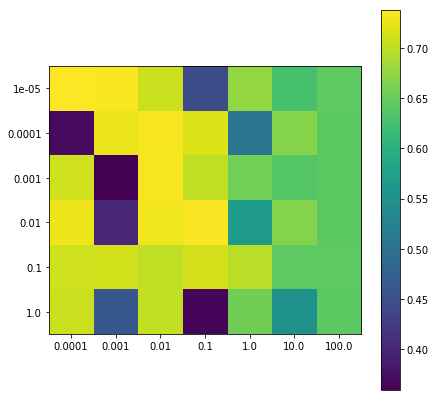

In [17]:
param_dict = {
    "eta0": np.logspace(-5, 0, 6),
    "alpha": np.logspace(-4, 2, 7),
}

default_params = {
    "loss": "log",
    "max_iter": 10000,
    "tol": 1e-3,
    "class_weight":"balanced",
    #"early_stopping":True
}
data = [
    x_train,
    x_test,
    y_train, 
    y_test
]

GS = GridSearch()
performance = GS.search(
    SGDClassifier,
    param_dict,
    data,
    default_params
)
GS.plot_performance(performance)

## Analysis 

In classification, as in regression, the estimation of which features are _salient_ or important to the prediction is important to the analysis. The explicit procedure by which you can do this is model dependent, for logistic regression the feature weights are indicators of feature importance (think back to task 1a for reasons that might modify this). Feature elimination can then be done by explicitly checking the coefficients and greedily removing them. For models where we can't extract explicit feature importance general way of measuring feature importance is by _recursive feature elimination_ which is just a fancy name for systematically picking out features you don't need by greedily checking how well your model does without it. 

### Task 4: Recursive Feature Elimination

In this task you shoud:

1. Use the provided code to perform feature extraction. The method included is model agnostic but suffers from performance issues. It's completely linear, it does a greedy search over all feature combinations leading to a long running time ( it goes as $\mathcal{O}(2^N)$ ). What ways do you see of improving this algorithm? 


In [19]:
from sklearn.metrics import accuracy_score
from itertools import chain, combinations
import numpy as np
import sklearn


def feature_selection(model, x_train, x_test, y_train, y_test, score=accuracy_score):
    """
    arguments: 
    ----------
    model: A model implementing .fit and .predict methods
    x_train: a N-samples x features matrix of data to train on
    y_train: targets to train against
    x_test: hold out set to estimate OOS error
    y_test: hold out targets to estimate OOS error
    
    kwargs:
    score: a score function measuring model performance, must implement __call__(y_true, y_pred)
    
    returns:
    which: index(indices) of the subset and performance corresponding to
        the minimum within one std of max performance 
    model_performance: array of all scores as measured by score 
    subsets: list describing the powerset of the features
    --------
    
    """
    
    n_features = x_train.shape[1]
    feature_indices = np.arange(n_features)
    
    #generate a powerset [abc]->[a], [b], [c], [ab], [ac], [bc], [abc]
    #to grab the columns from x for a given experiment
    subset_iterator = chain.from_iterable(combinations(feature_indices, i) for i in range(1, len(feature_indices)+1))
    model_performance = np.zeros(2**n_features)
    subsets = [0]*(2**n_features)

    for i, feature_subset in enumerate(subset_iterator):
        #select subset data
        train_subset = x_train[:, feature_subset]
        test_subset = x_test[:, feature_subset]
        #clone model with hyperparams but without weights to perform fitting
        subset_model = sklearn.base.clone(model)
        subset_model.fit(train_subset, y_train)
        #evaluate performance
        subset_performance = score(y_test, subset_model.predict(test_subset))
        
        #save configuration and performance
        model_performance[i] = subset_performance
        subsets[i] = feature_subset
    
    performance_std = model_performance.std()
    best_performance = model_performance.max()
    within_one_std = model_performance > (best_performance - performance_std)
    min_within_one_std = model_performance[within_one_std].min()

    which = np.where(model_performance == min_within_one_std)
    return which, model_performance, subsets